<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sklearn Tuner for CNN Activity Classifier - V2

In this notebook, we use SKlearn  to tune a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5830697819915717075
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14026761192917927219
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9042929706644495121
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3859967937030855165
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/tunecnn-sklearn-2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [3]:
# sklearn hyperparams
params = {
    'n_conv_1':[512, 768], # filters, a.k.a. kernels
    'k_conv_1':[2, 3], # kernel length
    'n_conv_2':[256, 512], # filters, a.k.a. kernels
    'k_conv_2':[2, 3], # kernel length
    'n_conv_3':[256, 512], # filters, a.k.a. kernels
    'k_conv_3':[2, 3], # kernel length
    'maxpooling_pool_size':[3],
    'avepooling_pool_size':[3],
    'n_dense_1':[256, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 512],
    'dropout_2':[0.25],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 30
cv = 3
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [6]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [7]:
y = to_categorical(labels_array_int, num_classes=n_class)


### Splitting and shuffeling the data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [9]:
params

{'n_conv_1': [512, 768],
 'k_conv_1': [2, 3],
 'n_conv_2': [256, 512],
 'k_conv_2': [2, 3],
 'n_conv_3': [256, 512],
 'k_conv_3': [2, 3],
 'maxpooling_pool_size': [3],
 'avepooling_pool_size': [3],
 'n_dense_1': [256, 512],
 'dropout_1': [0.2, 0.3],
 'n_dense_2': [256, 512],
 'dropout_2': [0.25],
 'activation_conv': ['elu',
  'relu',
 'activation_dense': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x1fab97d27c8>]}

In [10]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
#     model.summary()
    print(f"""n_conv_1 = {n_conv_1}, k_conv_1 = {k_conv_1},  n_conv_2 = {n_conv_2}, k_conv_2 = {k_conv_2}, 
          n_conv_3 = {n_conv_3},  k_conv_3 = {k_conv_3},  maxpooling_pool_size = {maxpooling_pool_size},
          avepooling_pool_size = {avepooling_pool_size},  n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [11]:
model_default = create_model()
model_default.summary()

n_conv_1 = 256, k_conv_1 = 3,  n_conv_2 = 256, k_conv_2 = 3, 
          n_conv_3 = 256,  k_conv_3 = 3,  maxpooling_pool_size = 2,
          avepooling_pool_size = 2,  n_dense_1 = 256, dropout_1 = 0.2,
          n_dense_2 = 256, dropout_2 = 0.2, activation_conv=  relu,
          activation_dense=  elu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D) 

In [12]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [13]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

n_conv_1 = 768, k_conv_1 = 2,  n_conv_2 = 256, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 3,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 512, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  elu,
          activation_dense=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FAC0EED048>
Epoch 1/60
152/152 [==============================] - 6s 41ms/step - loss: 1.1788 - accuracy: 0.5048
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 1.0486 - accuracy: 0.5526
Epoch 3/60
152/152 [==============================] - 6s 40ms/step - loss: 0.9630 - accuracy: 0.5897
Epoch 4/60
152/152 [==============================] - 6s 39ms/step - loss: 0.8955 - accuracy: 0.6246
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.8301 - accuracy: 0.6529
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.7811 - accuracy: 0.6744
Epo

152/152 [==============================] - 6s 39ms/step - loss: 0.6271 - accuracy: 0.7445
Epoch 11/60
152/152 [==============================] - 6s 40ms/step - loss: 0.6193 - accuracy: 0.7503
Epoch 12/60
152/152 [==============================] - 6s 39ms/step - loss: 0.5677 - accuracy: 0.7741
Epoch 13/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5533 - accuracy: 0.7795
Epoch 14/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5263 - accuracy: 0.7882
Epoch 15/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5086 - accuracy: 0.7976
Epoch 16/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4990 - accuracy: 0.8006
Epoch 17/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4848 - accuracy: 0.8096
Epoch 18/60
152/152 [==============================] - 6s 39ms/step - loss: 0.4683 - accuracy: 0.8171
Epoch 19/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4643 - accuracy:

152/152 [==============================] - 6s 40ms/step - loss: 0.4376 - accuracy: 0.8290
Epoch 24/60
152/152 [==============================] - 6s 39ms/step - loss: 0.4247 - accuracy: 0.8332
Epoch 25/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4270 - accuracy: 0.8311
Epoch 26/60
152/152 [==============================] - 6s 39ms/step - loss: 0.4198 - accuracy: 0.8361
Epoch 27/60
152/152 [==============================] - 6s 39ms/step - loss: 0.4111 - accuracy: 0.8393
Epoch 28/60
152/152 [==============================] - 6s 39ms/step - loss: 0.4040 - accuracy: 0.8433
Epoch 29/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3947 - accuracy: 0.8456
Epoch 30/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3836 - accuracy: 0.8494
Epoch 31/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3838 - accuracy: 0.8490
Epoch 32/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3796 - accuracy:

152/152 [==============================] - 6s 37ms/step - loss: 0.1552 - accuracy: 0.9424
Epoch 40/60
152/152 [==============================] - 6s 38ms/step - loss: 0.1468 - accuracy: 0.9438
Epoch 41/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1438 - accuracy: 0.9442
Epoch 42/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1369 - accuracy: 0.9484
Epoch 43/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1380 - accuracy: 0.9483
Epoch 44/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1386 - accuracy: 0.9471
Epoch 45/60
152/152 [==============================] - 6s 38ms/step - loss: 0.1369 - accuracy: 0.9466
Epoch 46/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1324 - accuracy: 0.9505
Epoch 47/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1248 - accuracy: 0.9523
Epoch 48/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1307 - accuracy:

152/152 [==============================] - 6s 36ms/step - loss: 0.1183 - accuracy: 0.9546
Epoch 56/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1226 - accuracy: 0.9534
Epoch 57/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1199 - accuracy: 0.9545
Epoch 58/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1098 - accuracy: 0.9592
Epoch 59/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1092 - accuracy: 0.9587
Epoch 60/60
76/76 [==============================] - 1s 14ms/step - loss: 0.2345 - accuracy: 0.9363
n_conv_1 = 768, k_conv_1 = 2,  n_conv_2 = 256, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 2,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 256, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  relu,
          activation_dense=  relu
Epoch 1/60
152/152 [==============================] - 6s 37ms/step - loss: 1.1071 - accuracy: 0.53

152/152 [==============================] - 4s 26ms/step - loss: 0.5594 - accuracy: 0.7778
Epoch 8/60
152/152 [==============================] - 4s 26ms/step - loss: 0.5140 - accuracy: 0.7992
Epoch 9/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4903 - accuracy: 0.8092
Epoch 10/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4599 - accuracy: 0.8203
Epoch 11/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4594 - accuracy: 0.8215
Epoch 12/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4519 - accuracy: 0.8242
Epoch 13/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4234 - accuracy: 0.8353
Epoch 14/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4099 - accuracy: 0.8405
Epoch 15/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4039 - accuracy: 0.8418
Epoch 16/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3914 - accuracy: 0

152/152 [==============================] - 4s 26ms/step - loss: 0.3546 - accuracy: 0.8633
Epoch 23/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3631 - accuracy: 0.8573
Epoch 24/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3437 - accuracy: 0.8661
Epoch 25/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3328 - accuracy: 0.8705
Epoch 26/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3276 - accuracy: 0.8723
Epoch 27/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3306 - accuracy: 0.8705
Epoch 28/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3223 - accuracy: 0.8729
Epoch 29/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3248 - accuracy: 0.8718
Epoch 30/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3237 - accuracy: 0.8734
Epoch 31/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3181 - accuracy:

152/152 [==============================] - 4s 26ms/step - loss: 0.3079 - accuracy: 0.8796
Epoch 38/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3003 - accuracy: 0.8828
Epoch 39/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3071 - accuracy: 0.8792
Epoch 40/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2910 - accuracy: 0.8876
Epoch 41/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2979 - accuracy: 0.8857
Epoch 42/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2961 - accuracy: 0.8850
Epoch 43/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2839 - accuracy: 0.8896
Epoch 44/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2829 - accuracy: 0.8901
Epoch 45/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2909 - accuracy: 0.8878
Epoch 46/60
152/152 [==============================] - 4s 26ms/step - loss: 0.2719 - accuracy:

152/152 [==============================] - 8s 50ms/step - loss: 0.2018 - accuracy: 0.9208
Epoch 52/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1971 - accuracy: 0.9230 0s - loss: 0.1959 
Epoch 53/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1942 - accuracy: 0.9247
Epoch 54/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1939 - accuracy: 0.9250
Epoch 55/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1891 - accuracy: 0.9250
Epoch 56/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1872 - accuracy: 0.9279
Epoch 57/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1874 - accuracy: 0.9274
Epoch 58/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1814 - accuracy: 0.9295
Epoch 59/60
152/152 [==============================] - 8s 50ms/step - loss: 0.1701 - accuracy: 0.9352
Epoch 60/60
76/76 [==============================] - 1s 19ms/step - loss: 0

152/152 [==============================] - 8s 50ms/step - loss: 1.1924 - accuracy: 0.4902
Epoch 2/60
152/152 [==============================] - 8s 50ms/step - loss: 1.0743 - accuracy: 0.5394
Epoch 3/60
152/152 [==============================] - 8s 50ms/step - loss: 1.0111 - accuracy: 0.5753
Epoch 4/60
152/152 [==============================] - 8s 50ms/step - loss: 0.9472 - accuracy: 0.6069
Epoch 5/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8716 - accuracy: 0.6341
Epoch 6/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8063 - accuracy: 0.6628
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7384 - accuracy: 0.6936
Epoch 8/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6761 - accuracy: 0.7245
Epoch 9/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6225 - accuracy: 0.7453
Epoch 10/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5778 - accuracy: 0.7623


152/152 [==============================] - 7s 48ms/step - loss: 0.2630 - accuracy: 0.9015
Epoch 12/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2551 - accuracy: 0.9048
Epoch 13/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2490 - accuracy: 0.9061
Epoch 14/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2424 - accuracy: 0.9079
Epoch 15/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2241 - accuracy: 0.9158
Epoch 16/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2255 - accuracy: 0.9153
Epoch 17/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2101 - accuracy: 0.9203
Epoch 18/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2153 - accuracy: 0.9194
Epoch 19/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2159 - accuracy: 0.9176
Epoch 20/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1973 - accuracy:

152/152 [==============================] - 7s 48ms/step - loss: 0.1834 - accuracy: 0.9304
Epoch 24/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1868 - accuracy: 0.9297
Epoch 25/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1782 - accuracy: 0.9319
Epoch 26/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1659 - accuracy: 0.9373
Epoch 27/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1623 - accuracy: 0.9366
Epoch 28/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1614 - accuracy: 0.9402
Epoch 29/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1544 - accuracy: 0.9413
Epoch 30/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1529 - accuracy: 0.9431
Epoch 31/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1570 - accuracy: 0.9405
Epoch 32/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1504 - accuracy:

152/152 [==============================] - 7s 48ms/step - loss: 0.1328 - accuracy: 0.9498
Epoch 37/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1281 - accuracy: 0.9511
Epoch 38/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1343 - accuracy: 0.9478
Epoch 39/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1273 - accuracy: 0.9519
Epoch 40/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1224 - accuracy: 0.9530
Epoch 41/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1218 - accuracy: 0.9531
Epoch 42/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1160 - accuracy: 0.9548
Epoch 43/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1268 - accuracy: 0.9524
Epoch 44/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1153 - accuracy: 0.9552
Epoch 45/60
152/152 [==============================] - 7s 48ms/step - loss: 0.1165 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.2649 - accuracy: 0.8966
Epoch 51/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2601 - accuracy: 0.8992
Epoch 52/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2561 - accuracy: 0.9013
Epoch 53/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2539 - accuracy: 0.9036
Epoch 54/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2573 - accuracy: 0.8988
Epoch 55/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2482 - accuracy: 0.9043
Epoch 56/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2473 - accuracy: 0.9044
Epoch 57/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2451 - accuracy: 0.9045
Epoch 58/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2481 - accuracy: 0.9048
Epoch 59/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2372 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.9253 - accuracy: 0.6052
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7886 - accuracy: 0.6789
Epoch 4/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6867 - accuracy: 0.7211
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6448 - accuracy: 0.7417
Epoch 6/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6008 - accuracy: 0.7593
Epoch 7/60
152/152 [==============================] - 5s 35ms/step - loss: 0.5693 - accuracy: 0.7749
Epoch 8/60
152/152 [==============================] - 5s 35ms/step - loss: 0.5377 - accuracy: 0.7882
Epoch 9/60
152/152 [==============================] - 5s 35ms/step - loss: 0.5382 - accuracy: 0.7898
Epoch 10/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4912 - accuracy: 0.8096
Epoch 11/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4730 - accuracy: 0.8142

152/152 [==============================] - 6s 39ms/step - loss: 0.3874 - accuracy: 0.8505
Epoch 18/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3824 - accuracy: 0.8524
Epoch 19/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3932 - accuracy: 0.8448
Epoch 20/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3623 - accuracy: 0.8578
Epoch 21/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3693 - accuracy: 0.8611
Epoch 22/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3592 - accuracy: 0.8585
Epoch 23/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3489 - accuracy: 0.8645
Epoch 24/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3547 - accuracy: 0.8626
Epoch 25/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3489 - accuracy: 0.8637
Epoch 26/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3406 - accuracy:

152/152 [==============================] - 6s 38ms/step - loss: 0.3165 - accuracy: 0.8751
Epoch 33/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3129 - accuracy: 0.8757
Epoch 34/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3098 - accuracy: 0.8766
Epoch 35/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3074 - accuracy: 0.8762
Epoch 36/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3093 - accuracy: 0.8770
Epoch 37/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3040 - accuracy: 0.8791
Epoch 38/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2980 - accuracy: 0.8793
Epoch 39/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2938 - accuracy: 0.8814
Epoch 40/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3035 - accuracy: 0.8799
Epoch 41/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3301 - accuracy:

152/152 [==============================] - 6s 38ms/step - loss: 0.2725 - accuracy: 0.8895
Epoch 48/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2800 - accuracy: 0.8865
Epoch 49/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2738 - accuracy: 0.8892
Epoch 50/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2629 - accuracy: 0.8924
Epoch 51/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2697 - accuracy: 0.8902
Epoch 52/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2734 - accuracy: 0.8896
Epoch 53/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2602 - accuracy: 0.8950
Epoch 54/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2576 - accuracy: 0.8950
Epoch 55/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2573 - accuracy: 0.8943
Epoch 56/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2686 - accuracy:

Epoch 1/60
152/152 [==============================] - 4s 28ms/step - loss: 1.1110 - accuracy: 0.5242
Epoch 2/60
152/152 [==============================] - 4s 28ms/step - loss: 0.8844 - accuracy: 0.6229
Epoch 3/60
152/152 [==============================] - 4s 28ms/step - loss: 0.7807 - accuracy: 0.6660
Epoch 4/60
152/152 [==============================] - 4s 28ms/step - loss: 0.7048 - accuracy: 0.7047
Epoch 5/60
152/152 [==============================] - 4s 28ms/step - loss: 0.6487 - accuracy: 0.7298
Epoch 6/60
152/152 [==============================] - 4s 28ms/step - loss: 0.5779 - accuracy: 0.7662
Epoch 7/60
152/152 [==============================] - 4s 28ms/step - loss: 0.5440 - accuracy: 0.7809
Epoch 8/60
152/152 [==============================] - 4s 28ms/step - loss: 0.5128 - accuracy: 0.7950
Epoch 9/60
152/152 [==============================] - 4s 28ms/step - loss: 0.4678 - accuracy: 0.8177
Epoch 10/60
152/152 [==============================] - 4s 28ms/step - loss: 0.4506 - accura

152/152 [==============================] - 4s 28ms/step - loss: 0.3803 - accuracy: 0.8524
Epoch 17/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3971 - accuracy: 0.8446
Epoch 18/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3647 - accuracy: 0.8570
Epoch 19/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3683 - accuracy: 0.8570
Epoch 20/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3511 - accuracy: 0.8619
Epoch 21/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3576 - accuracy: 0.8609
Epoch 22/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3559 - accuracy: 0.8610
Epoch 23/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3401 - accuracy: 0.8660
Epoch 24/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3342 - accuracy: 0.8682
Epoch 25/60
152/152 [==============================] - 4s 28ms/step - loss: 0.3332 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.1613 - accuracy: 0.9386
Epoch 31/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1567 - accuracy: 0.9414
Epoch 32/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1552 - accuracy: 0.9412
Epoch 33/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1531 - accuracy: 0.9420
Epoch 34/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1403 - accuracy: 0.9468
Epoch 35/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1430 - accuracy: 0.9457
Epoch 36/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1410 - accuracy: 0.9469
Epoch 37/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1449 - accuracy: 0.9466
Epoch 38/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1309 - accuracy: 0.9504
Epoch 39/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1347 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.1137 - accuracy: 0.9574
Epoch 47/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1035 - accuracy: 0.9603
Epoch 48/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1049 - accuracy: 0.9602
Epoch 49/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1053 - accuracy: 0.9605
Epoch 50/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1051 - accuracy: 0.9597
Epoch 51/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1083 - accuracy: 0.9587
Epoch 52/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0958 - accuracy: 0.9626
Epoch 53/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0996 - accuracy: 0.9620
Epoch 54/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0995 - accuracy: 0.9619
Epoch 55/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0932 - accuracy:

Epoch 1/60
152/152 [==============================] - 4s 24ms/step - loss: 1.1704 - accuracy: 0.5032
Epoch 2/60
152/152 [==============================] - 3s 23ms/step - loss: 0.9527 - accuracy: 0.6054
Epoch 3/60
152/152 [==============================] - 3s 23ms/step - loss: 0.8193 - accuracy: 0.6664
Epoch 4/60
152/152 [==============================] - 3s 23ms/step - loss: 0.7746 - accuracy: 0.6855
Epoch 5/60
152/152 [==============================] - 3s 23ms/step - loss: 0.7365 - accuracy: 0.7031
Epoch 6/60
152/152 [==============================] - 3s 23ms/step - loss: 0.6953 - accuracy: 0.7199
Epoch 7/60
152/152 [==============================] - 3s 23ms/step - loss: 0.6837 - accuracy: 0.7251
Epoch 8/60
152/152 [==============================] - 3s 23ms/step - loss: 0.6533 - accuracy: 0.7376
Epoch 9/60
152/152 [==============================] - 3s 23ms/step - loss: 0.6376 - accuracy: 0.7445
Epoch 10/60
152/152 [==============================] - 3s 23ms/step - loss: 0.6178 - accura

152/152 [==============================] - 3s 23ms/step - loss: 0.5779 - accuracy: 0.7686
Epoch 14/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5693 - accuracy: 0.7734
Epoch 15/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5461 - accuracy: 0.7821
Epoch 16/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5336 - accuracy: 0.7881
Epoch 17/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5234 - accuracy: 0.7923
Epoch 18/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5099 - accuracy: 0.7996
Epoch 19/60
152/152 [==============================] - 3s 23ms/step - loss: 0.5032 - accuracy: 0.8035
Epoch 20/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4891 - accuracy: 0.8080 0s - los
Epoch 21/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4825 - accuracy: 0.8105
Epoch 22/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4635 - 

152/152 [==============================] - 3s 23ms/step - loss: 0.4322 - accuracy: 0.8320
Epoch 29/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4318 - accuracy: 0.8334
Epoch 30/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4225 - accuracy: 0.8364
Epoch 31/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4239 - accuracy: 0.8371
Epoch 32/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4110 - accuracy: 0.8418
Epoch 33/60
152/152 [==============================] - 3s 23ms/step - loss: 0.4173 - accuracy: 0.8383
Epoch 34/60
152/152 [==============================] - 3s 23ms/step - loss: 0.3989 - accuracy: 0.8475
Epoch 35/60
152/152 [==============================] - 3s 23ms/step - loss: 0.3945 - accuracy: 0.8489
Epoch 36/60
152/152 [==============================] - 3s 23ms/step - loss: 0.3951 - accuracy: 0.8494
Epoch 37/60
152/152 [==============================] - 3s 23ms/step - loss: 0.3894 - accuracy:

152/152 [==============================] - 5s 34ms/step - loss: 0.1376 - accuracy: 0.9482
Epoch 43/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1345 - accuracy: 0.9503
Epoch 44/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1302 - accuracy: 0.9510
Epoch 45/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1363 - accuracy: 0.9485
Epoch 46/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1272 - accuracy: 0.9514
Epoch 47/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1357 - accuracy: 0.9505
Epoch 48/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1206 - accuracy: 0.9541
Epoch 49/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1254 - accuracy: 0.9516
Epoch 50/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1192 - accuracy: 0.9550
Epoch 51/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1145 - accuracy:

152/152 [==============================] - 5s 34ms/step - loss: 0.1147 - accuracy: 0.9575
Epoch 57/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1098 - accuracy: 0.9591
Epoch 58/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1099 - accuracy: 0.9583
Epoch 59/60
152/152 [==============================] - 5s 34ms/step - loss: 0.1041 - accuracy: 0.9615
Epoch 60/60
76/76 [==============================] - 1s 13ms/step - loss: 0.2575 - accuracy: 0.9347
n_conv_1 = 512, k_conv_1 = 3,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 256,  k_conv_3 = 3,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 256, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  relu,
          activation_dense=  relu
Epoch 1/60
152/152 [==============================] - 5s 35ms/step - loss: 1.0855 - accuracy: 0.5471
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.7296 - accuracy: 0.711

152/152 [==============================] - 6s 37ms/step - loss: 0.3194 - accuracy: 0.8844
Epoch 9/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2907 - accuracy: 0.8945
Epoch 10/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2876 - accuracy: 0.8952
Epoch 11/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2651 - accuracy: 0.9015
Epoch 12/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2549 - accuracy: 0.9054
Epoch 13/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2446 - accuracy: 0.9088
Epoch 14/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2334 - accuracy: 0.9133
Epoch 15/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2311 - accuracy: 0.9152
Epoch 16/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2208 - accuracy: 0.9196
Epoch 17/60
152/152 [==============================] - 6s 37ms/step - loss: 0.2093 - accuracy: 

152/152 [==============================] - 6s 37ms/step - loss: 0.1740 - accuracy: 0.9340
Epoch 25/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1823 - accuracy: 0.9324
Epoch 26/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1729 - accuracy: 0.9340
Epoch 27/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1691 - accuracy: 0.9378
Epoch 28/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1648 - accuracy: 0.9383
Epoch 29/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1620 - accuracy: 0.9392
Epoch 30/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1613 - accuracy: 0.9403
Epoch 31/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1525 - accuracy: 0.9433
Epoch 32/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1516 - accuracy: 0.9426
Epoch 33/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1454 - accuracy:

152/152 [==============================] - 6s 36ms/step - loss: 0.1227 - accuracy: 0.9537
Epoch 41/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1289 - accuracy: 0.9517
Epoch 42/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1261 - accuracy: 0.9520
Epoch 43/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1238 - accuracy: 0.9535
Epoch 44/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1259 - accuracy: 0.9526
Epoch 45/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1206 - accuracy: 0.9553
Epoch 46/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1148 - accuracy: 0.9566
Epoch 47/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1120 - accuracy: 0.9585
Epoch 48/60
152/152 [==============================] - 6s 36ms/step - loss: 0.1132 - accuracy: 0.9568
Epoch 49/60
152/152 [==============================] - 6s 37ms/step - loss: 0.1070 - accuracy:

152/152 [==============================] - 4s 25ms/step - loss: 0.2507 - accuracy: 0.9015
Epoch 56/60
152/152 [==============================] - 4s 25ms/step - loss: 0.2438 - accuracy: 0.9054
Epoch 57/60
152/152 [==============================] - 4s 25ms/step - loss: 0.2459 - accuracy: 0.9038
Epoch 58/60
152/152 [==============================] - 4s 25ms/step - loss: 0.2422 - accuracy: 0.9048
Epoch 59/60
152/152 [==============================] - 4s 25ms/step - loss: 0.2431 - accuracy: 0.9037
Epoch 60/60
76/76 [==============================] - 1s 10ms/step - loss: 0.3145 - accuracy: 0.8856
n_conv_1 = 512, k_conv_1 = 2,  n_conv_2 = 256, k_conv_2 = 2, 
          n_conv_3 = 512,  k_conv_3 = 3,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 512, dropout_1 = 0.2,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FAC93DE608>,
          activation_dense=  relu
Epoch 1/60

152/152 [==============================] - 4s 25ms/step - loss: 0.6487 - accuracy: 0.7296
Epoch 6/60
152/152 [==============================] - 4s 25ms/step - loss: 0.5992 - accuracy: 0.7546
Epoch 7/60
152/152 [==============================] - 4s 25ms/step - loss: 0.5620 - accuracy: 0.7755
Epoch 8/60
152/152 [==============================] - 4s 25ms/step - loss: 0.5176 - accuracy: 0.7918
Epoch 9/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4773 - accuracy: 0.8118
Epoch 10/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4666 - accuracy: 0.8168
Epoch 11/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4617 - accuracy: 0.8182
Epoch 12/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4292 - accuracy: 0.8299
Epoch 13/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4132 - accuracy: 0.8394
Epoch 14/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4059 - accuracy: 0.8

152/152 [==============================] - 4s 23ms/step - loss: 0.3664 - accuracy: 0.8602
Epoch 21/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3718 - accuracy: 0.8556
Epoch 22/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3601 - accuracy: 0.8615
Epoch 23/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3567 - accuracy: 0.8652
Epoch 24/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3428 - accuracy: 0.8708
Epoch 25/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3469 - accuracy: 0.8660
Epoch 26/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3515 - accuracy: 0.8645
Epoch 27/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3415 - accuracy: 0.8690
Epoch 28/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3419 - accuracy: 0.8698
Epoch 29/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3422 - accuracy:

152/152 [==============================] - 4s 23ms/step - loss: 0.3068 - accuracy: 0.8800
Epoch 36/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3254 - accuracy: 0.8747
Epoch 37/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3017 - accuracy: 0.8824
Epoch 38/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3084 - accuracy: 0.8808
Epoch 39/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3043 - accuracy: 0.8820
Epoch 40/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2922 - accuracy: 0.8869
Epoch 41/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3158 - accuracy: 0.8782
Epoch 42/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2901 - accuracy: 0.8865
Epoch 43/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3116 - accuracy: 0.8774
Epoch 44/60
152/152 [==============================] - 4s 23ms/step - loss: 0.3000 - accuracy:

152/152 [==============================] - 4s 23ms/step - loss: 0.2904 - accuracy: 0.8860
Epoch 51/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2892 - accuracy: 0.8900
Epoch 52/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2874 - accuracy: 0.8871
Epoch 53/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2815 - accuracy: 0.8907
Epoch 54/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2835 - accuracy: 0.8913
Epoch 55/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2880 - accuracy: 0.8896
Epoch 56/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2823 - accuracy: 0.8913
Epoch 57/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2748 - accuracy: 0.8915
Epoch 58/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2770 - accuracy: 0.8904
Epoch 59/60
152/152 [==============================] - 4s 23ms/step - loss: 0.2793 - accuracy:

152/152 [==============================] - 7s 48ms/step - loss: 1.1280 - accuracy: 0.5182
Epoch 2/60
152/152 [==============================] - 7s 49ms/step - loss: 0.9059 - accuracy: 0.6261
Epoch 3/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7757 - accuracy: 0.6830
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.7266 - accuracy: 0.7049
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6877 - accuracy: 0.7211
Epoch 6/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6381 - accuracy: 0.7412
Epoch 7/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6100 - accuracy: 0.7547
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.5715 - accuracy: 0.7724
Epoch 9/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5460 - accuracy: 0.7805
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.5180 - accuracy: 0.7947


152/152 [==============================] - 7s 48ms/step - loss: 0.4849 - accuracy: 0.8096
Epoch 15/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4630 - accuracy: 0.8200
Epoch 16/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4621 - accuracy: 0.8194
Epoch 17/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4470 - accuracy: 0.8259
Epoch 18/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4316 - accuracy: 0.8313
Epoch 19/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4263 - accuracy: 0.8330
Epoch 20/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4260 - accuracy: 0.8347
Epoch 21/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4083 - accuracy: 0.8418
Epoch 22/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4096 - accuracy: 0.8400
Epoch 23/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4068 - accuracy:

152/152 [==============================] - 4s 24ms/step - loss: 0.1563 - accuracy: 0.9401
Epoch 31/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1584 - accuracy: 0.9397
Epoch 32/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1545 - accuracy: 0.9422
Epoch 33/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1487 - accuracy: 0.9426
Epoch 34/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1454 - accuracy: 0.9447
Epoch 35/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1430 - accuracy: 0.9454
Epoch 36/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1418 - accuracy: 0.9440
Epoch 37/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1415 - accuracy: 0.9462
Epoch 38/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1339 - accuracy: 0.9493
Epoch 39/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1269 - accuracy:

152/152 [==============================] - 4s 24ms/step - loss: 0.1162 - accuracy: 0.9560
Epoch 47/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1010 - accuracy: 0.9623
Epoch 48/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1059 - accuracy: 0.9598
Epoch 49/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1046 - accuracy: 0.9597
Epoch 50/60
152/152 [==============================] - 4s 25ms/step - loss: 0.0997 - accuracy: 0.9624
Epoch 51/60
152/152 [==============================] - 4s 24ms/step - loss: 0.0976 - accuracy: 0.9629
Epoch 52/60
152/152 [==============================] - 4s 25ms/step - loss: 0.0990 - accuracy: 0.9621
Epoch 53/60
152/152 [==============================] - 4s 25ms/step - loss: 0.0950 - accuracy: 0.9647
Epoch 54/60
152/152 [==============================] - 4s 25ms/step - loss: 0.1016 - accuracy: 0.9618
Epoch 55/60
152/152 [==============================] - 4s 25ms/step - loss: 0.0957 - accuracy:

Epoch 1/60
152/152 [==============================] - 5s 34ms/step - loss: 1.0336 - accuracy: 0.5594
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6673 - accuracy: 0.7394
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4901 - accuracy: 0.8161
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4102 - accuracy: 0.8485
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3627 - accuracy: 0.8669
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3378 - accuracy: 0.8759 1s
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3176 - accuracy: 0.8826
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2999 - accuracy: 0.8901
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2927 - accuracy: 0.8917
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2769 - acc

152/152 [==============================] - 5s 31ms/step - loss: 0.2126 - accuracy: 0.9216
Epoch 18/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2102 - accuracy: 0.9214
Epoch 19/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2061 - accuracy: 0.9249
Epoch 20/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1950 - accuracy: 0.9273
Epoch 21/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2000 - accuracy: 0.9258
Epoch 22/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1907 - accuracy: 0.9292
Epoch 23/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1856 - accuracy: 0.9298
Epoch 24/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1789 - accuracy: 0.9327
Epoch 25/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1794 - accuracy: 0.9340
Epoch 26/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1717 - accuracy:

152/152 [==============================] - 5s 31ms/step - loss: 0.1544 - accuracy: 0.9420
Epoch 32/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1508 - accuracy: 0.9445
Epoch 33/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1437 - accuracy: 0.9470
Epoch 34/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1567 - accuracy: 0.9422
Epoch 35/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1434 - accuracy: 0.9466
Epoch 36/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1364 - accuracy: 0.9491
Epoch 37/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1358 - accuracy: 0.9489
Epoch 38/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1275 - accuracy: 0.9530
Epoch 39/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1311 - accuracy: 0.9514
Epoch 40/60
152/152 [==============================] - 5s 31ms/step - loss: 0.1295 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.3052 - accuracy: 0.8798
Epoch 47/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3054 - accuracy: 0.8809
Epoch 48/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3125 - accuracy: 0.8763
Epoch 49/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3057 - accuracy: 0.8785
Epoch 50/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2955 - accuracy: 0.8840
Epoch 51/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2975 - accuracy: 0.8832
Epoch 52/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2894 - accuracy: 0.8848
Epoch 53/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2893 - accuracy: 0.8849
Epoch 54/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2923 - accuracy: 0.8838
Epoch 55/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2889 - accuracy:

n_conv_1 = 512, k_conv_1 = 2,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 256,  k_conv_3 = 2,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 256, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FBE757F748>,
          activation_dense=  elu
Epoch 1/60
152/152 [==============================] - 5s 35ms/step - loss: 1.1081 - accuracy: 0.5246
Epoch 2/60
152/152 [==============================] - 5s 35ms/step - loss: 0.8825 - accuracy: 0.6226
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7990 - accuracy: 0.6561
Epoch 4/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7349 - accuracy: 0.6887
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6830 - accuracy: 0.7181
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6199 - accuracy: 0.7534
Epo

152/152 [==============================] - 6s 42ms/step - loss: 0.5209 - accuracy: 0.7944
Epoch 14/60
152/152 [==============================] - 6s 42ms/step - loss: 0.4836 - accuracy: 0.8115
Epoch 15/60
152/152 [==============================] - 6s 43ms/step - loss: 0.4604 - accuracy: 0.8208
Epoch 16/60
152/152 [==============================] - 6s 42ms/step - loss: 0.4382 - accuracy: 0.8285
Epoch 17/60
152/152 [==============================] - 6s 43ms/step - loss: 0.4149 - accuracy: 0.8390
Epoch 18/60
152/152 [==============================] - 6s 42ms/step - loss: 0.4112 - accuracy: 0.8398
Epoch 19/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3960 - accuracy: 0.8441
Epoch 20/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3765 - accuracy: 0.8557
Epoch 21/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3734 - accuracy: 0.8557
Epoch 22/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3599 - accuracy:

152/152 [==============================] - 6s 42ms/step - loss: 0.3246 - accuracy: 0.8737
Epoch 28/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3107 - accuracy: 0.8775
Epoch 29/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3070 - accuracy: 0.8797
Epoch 30/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3078 - accuracy: 0.8794
Epoch 31/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3010 - accuracy: 0.8835
Epoch 32/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2882 - accuracy: 0.8859
Epoch 33/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2854 - accuracy: 0.8869
Epoch 34/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2834 - accuracy: 0.8890
Epoch 35/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2898 - accuracy: 0.8875
Epoch 36/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2705 - accuracy:

152/152 [==============================] - 6s 42ms/step - loss: 0.2488 - accuracy: 0.9017
Epoch 44/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2511 - accuracy: 0.9026
Epoch 45/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2441 - accuracy: 0.9061
Epoch 46/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2444 - accuracy: 0.9039
Epoch 47/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2427 - accuracy: 0.9064
Epoch 48/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2399 - accuracy: 0.9075
Epoch 49/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2380 - accuracy: 0.9068
Epoch 50/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2330 - accuracy: 0.9103
Epoch 51/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2360 - accuracy: 0.9085
Epoch 52/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2318 - accuracy:

152/152 [==============================] - 6s 38ms/step - loss: 0.2910 - accuracy: 0.8829
Epoch 57/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2909 - accuracy: 0.8827
Epoch 58/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2803 - accuracy: 0.8876
Epoch 59/60
152/152 [==============================] - 6s 38ms/step - loss: 0.2846 - accuracy: 0.8844
Epoch 60/60
76/76 [==============================] - 1s 14ms/step - loss: 0.3152 - accuracy: 0.8890
n_conv_1 = 768, k_conv_1 = 3,  n_conv_2 = 256, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 3,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 512, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  elu,
          activation_dense=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FBE75AA748>
Epoch 1/60
152/152 [==============================] - 6s 38ms/step - loss: 1.1762 - accuracy: 0.4982
Epoch 2/60
1

152/152 [==============================] - 6s 38ms/step - loss: 0.6668 - accuracy: 0.7343
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6280 - accuracy: 0.7477
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6102 - accuracy: 0.7547
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5903 - accuracy: 0.7660
Epoch 11/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5620 - accuracy: 0.7759
Epoch 12/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5533 - accuracy: 0.7807
Epoch 13/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5329 - accuracy: 0.7890
Epoch 14/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5198 - accuracy: 0.7957
Epoch 15/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5074 - accuracy: 0.7998
Epoch 16/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4959 - accuracy: 0

152/152 [==============================] - 6s 42ms/step - loss: 0.3326 - accuracy: 0.8709
Epoch 24/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3202 - accuracy: 0.8749
Epoch 25/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3203 - accuracy: 0.8752
Epoch 26/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3221 - accuracy: 0.8770
Epoch 27/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3056 - accuracy: 0.8814
Epoch 28/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3087 - accuracy: 0.8791
Epoch 29/60
152/152 [==============================] - 6s 42ms/step - loss: 0.3085 - accuracy: 0.8822
Epoch 30/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2951 - accuracy: 0.8865
Epoch 31/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2956 - accuracy: 0.8866
Epoch 32/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2917 - accuracy:

152/152 [==============================] - 6s 42ms/step - loss: 0.2637 - accuracy: 0.8963
Epoch 40/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2692 - accuracy: 0.8957
Epoch 41/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2734 - accuracy: 0.8937
Epoch 42/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2663 - accuracy: 0.8967
Epoch 43/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2539 - accuracy: 0.9001
Epoch 44/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2514 - accuracy: 0.9035
Epoch 45/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2528 - accuracy: 0.9014
Epoch 46/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2616 - accuracy: 0.8992
Epoch 47/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2416 - accuracy: 0.9040
Epoch 48/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2451 - accuracy:

152/152 [==============================] - 6s 42ms/step - loss: 0.2363 - accuracy: 0.9106
Epoch 54/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2404 - accuracy: 0.9072
Epoch 55/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2284 - accuracy: 0.9107
Epoch 56/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2127 - accuracy: 0.9174
Epoch 57/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2214 - accuracy: 0.9155
Epoch 58/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2166 - accuracy: 0.9165
Epoch 59/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2258 - accuracy: 0.9114
Epoch 60/60
76/76 [==============================] - 1s 16ms/step - loss: 0.2957 - accuracy: 0.9006
n_conv_1 = 512, k_conv_1 = 2,  n_conv_2 = 512, k_conv_2 = 2, 
          n_conv_3 = 256,  k_conv_3 = 3,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 512, dropout_1 = 0.

152/152 [==============================] - 5s 31ms/step - loss: 0.8748 - accuracy: 0.6331
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.8246 - accuracy: 0.6534
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7684 - accuracy: 0.6833
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7417 - accuracy: 0.6935
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7002 - accuracy: 0.7146
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6635 - accuracy: 0.7297
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.6297 - accuracy: 0.7428
Epoch 11/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5972 - accuracy: 0.7593
Epoch 12/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5669 - accuracy: 0.7743
Epoch 13/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5370 - accuracy: 0.78

Epoch 19/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4622 - accuracy: 0.8194
Epoch 20/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4469 - accuracy: 0.8232
Epoch 21/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4411 - accuracy: 0.8263
Epoch 22/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4408 - accuracy: 0.8276
Epoch 23/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4322 - accuracy: 0.8314
Epoch 24/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4156 - accuracy: 0.8360
Epoch 25/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4123 - accuracy: 0.8385
Epoch 26/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4076 - accuracy: 0.8382
Epoch 27/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4067 - accuracy: 0.8402
Epoch 28/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3946

152/152 [==============================] - 5s 32ms/step - loss: 0.1485 - accuracy: 0.9450
Epoch 36/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1455 - accuracy: 0.9459 0s - loss: 0.1435 - ac
Epoch 37/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1459 - accuracy: 0.9456
Epoch 38/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1391 - accuracy: 0.9480
Epoch 39/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1367 - accuracy: 0.9492
Epoch 40/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1380 - accuracy: 0.9485
Epoch 41/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1267 - accuracy: 0.9523
Epoch 42/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1261 - accuracy: 0.9523
Epoch 43/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1271 - accuracy: 0.9526
Epoch 44/60
152/152 [==============================] - 5s 32ms/step - l

152/152 [==============================] - 5s 32ms/step - loss: 0.1119 - accuracy: 0.9582
Epoch 52/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1136 - accuracy: 0.9576
Epoch 53/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1041 - accuracy: 0.9601
Epoch 54/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1070 - accuracy: 0.9589
Epoch 55/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1136 - accuracy: 0.9576
Epoch 56/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1040 - accuracy: 0.9611
Epoch 57/60
152/152 [==============================] - 5s 32ms/step - loss: 0.0981 - accuracy: 0.9630
Epoch 58/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1148 - accuracy: 0.9582
Epoch 59/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1084 - accuracy: 0.9600
Epoch 60/60
76/76 [==============================] - 1s 12ms/step - loss: 0.2538 - accuracy: 0

Epoch 1/60
152/152 [==============================] - 4s 26ms/step - loss: 1.1123 - accuracy: 0.5274
Epoch 2/60
152/152 [==============================] - 4s 26ms/step - loss: 0.7873 - accuracy: 0.6770
Epoch 3/60
152/152 [==============================] - 4s 26ms/step - loss: 0.6838 - accuracy: 0.7266
Epoch 4/60
152/152 [==============================] - 4s 26ms/step - loss: 0.6077 - accuracy: 0.7580
Epoch 5/60
152/152 [==============================] - 4s 26ms/step - loss: 0.5790 - accuracy: 0.7691
Epoch 6/60
152/152 [==============================] - 4s 26ms/step - loss: 0.5414 - accuracy: 0.7848
Epoch 7/60
152/152 [==============================] - 4s 26ms/step - loss: 0.5143 - accuracy: 0.7982
Epoch 8/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4844 - accuracy: 0.8122
Epoch 9/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4605 - accuracy: 0.8221
Epoch 10/60
152/152 [==============================] - 4s 26ms/step - loss: 0.4447 - accura

152/152 [==============================] - 4s 26ms/step - loss: 0.3977 - accuracy: 0.8480
Epoch 16/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3859 - accuracy: 0.8503
Epoch 17/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3760 - accuracy: 0.8583
Epoch 18/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3611 - accuracy: 0.8613
Epoch 19/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3619 - accuracy: 0.8619
Epoch 20/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3691 - accuracy: 0.8605
Epoch 21/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3500 - accuracy: 0.8671
Epoch 22/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3432 - accuracy: 0.8699
Epoch 23/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3518 - accuracy: 0.8676
Epoch 24/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3489 - accuracy:

Epoch 30/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3400 - accuracy: 0.8691
Epoch 31/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3285 - accuracy: 0.8718
Epoch 32/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3211 - accuracy: 0.8749
Epoch 33/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3163 - accuracy: 0.8769
Epoch 34/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3224 - accuracy: 0.8736
Epoch 35/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3178 - accuracy: 0.8754
Epoch 36/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3117 - accuracy: 0.8769
Epoch 37/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3104 - accuracy: 0.8772
Epoch 38/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3086 - accuracy: 0.8792
Epoch 39/60
152/152 [==============================] - 4s 26ms/step - loss: 0.3134

152/152 [==============================] - 4s 24ms/step - loss: 0.1340 - accuracy: 0.9494
Epoch 46/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1166 - accuracy: 0.9549
Epoch 47/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1178 - accuracy: 0.9539
Epoch 48/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1157 - accuracy: 0.9564
Epoch 49/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1225 - accuracy: 0.9528
Epoch 50/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1178 - accuracy: 0.9549
Epoch 51/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1108 - accuracy: 0.9583
Epoch 52/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1118 - accuracy: 0.9579
Epoch 53/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1174 - accuracy: 0.9558
Epoch 54/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1039 - accuracy:

76/76 [==============================] - 1s 10ms/step - loss: 0.2668 - accuracy: 0.9341
n_conv_1 = 512, k_conv_1 = 2,  n_conv_2 = 256, k_conv_2 = 2, 
          n_conv_3 = 512,  k_conv_3 = 2,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 512, dropout_1 = 0.2,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  relu,
          activation_dense=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FBEB3BCD88>
Epoch 1/60
152/152 [==============================] - 4s 24ms/step - loss: 1.0690 - accuracy: 0.5455
Epoch 2/60
152/152 [==============================] - 4s 24ms/step - loss: 0.7486 - accuracy: 0.6915
Epoch 3/60
152/152 [==============================] - 4s 24ms/step - loss: 0.5903 - accuracy: 0.7687
Epoch 4/60
152/152 [==============================] - 4s 24ms/step - loss: 0.4877 - accuracy: 0.8124
Epoch 5/60
152/152 [==============================] - 4s 24ms/step - loss: 0.4253 - accuracy: 0.8396
Epoch 6/60
152/

152/152 [==============================] - 5s 32ms/step - loss: 0.2408 - accuracy: 0.9128
Epoch 13/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2393 - accuracy: 0.9118
Epoch 14/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2345 - accuracy: 0.9122
Epoch 15/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2184 - accuracy: 0.9193
Epoch 16/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2212 - accuracy: 0.9177
Epoch 17/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2020 - accuracy: 0.9247
Epoch 18/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1959 - accuracy: 0.9265
Epoch 19/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1951 - accuracy: 0.9272
Epoch 20/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1909 - accuracy: 0.9295
Epoch 21/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1847 - accuracy:

152/152 [==============================] - 5s 32ms/step - loss: 0.1555 - accuracy: 0.9399 0s - loss: 0.1551 - accuracy: 0.
Epoch 29/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1572 - accuracy: 0.9409
Epoch 30/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1616 - accuracy: 0.9410
Epoch 31/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1510 - accuracy: 0.9442
Epoch 32/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1446 - accuracy: 0.9459
Epoch 33/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1369 - accuracy: 0.9485
Epoch 34/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1427 - accuracy: 0.9459
Epoch 35/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1266 - accuracy: 0.9518
Epoch 36/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1474 - accuracy: 0.9454
Epoch 37/60
152/152 [==============================] - 5s 32m

152/152 [==============================] - 5s 32ms/step - loss: 0.1189 - accuracy: 0.9551
Epoch 45/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1160 - accuracy: 0.9560
Epoch 46/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1082 - accuracy: 0.9586
Epoch 47/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1127 - accuracy: 0.9573
Epoch 48/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1086 - accuracy: 0.9592
Epoch 49/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1082 - accuracy: 0.9582
Epoch 50/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1161 - accuracy: 0.9561
Epoch 51/60
152/152 [==============================] - 5s 32ms/step - loss: 0.0973 - accuracy: 0.9623
Epoch 52/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1036 - accuracy: 0.9602
Epoch 53/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1079 - accuracy:

152/152 [==============================] - 6s 37ms/step - loss: 0.2957 - accuracy: 0.8839
Epoch 58/60
152/152 [==============================] - 6s 36ms/step - loss: 0.2896 - accuracy: 0.8855
Epoch 59/60
152/152 [==============================] - 6s 36ms/step - loss: 0.2808 - accuracy: 0.8877
Epoch 60/60
76/76 [==============================] - 1s 14ms/step - loss: 0.3074 - accuracy: 0.8841
n_conv_1 = 512, k_conv_1 = 2,  n_conv_2 = 512, k_conv_2 = 3, 
          n_conv_3 = 512,  k_conv_3 = 2,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 256, dropout_1 = 0.3,
          n_dense_2 = 512, dropout_2 = 0.25, activation_conv=  elu,
          activation_dense=  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001FAD8963AC8>
Epoch 1/60
152/152 [==============================] - 6s 36ms/step - loss: 1.1796 - accuracy: 0.4994
Epoch 2/60
152/152 [==============================] - 6s 36ms/step - loss: 1.0481 - accuracy: 0.5526
Epoch 3/60
15

152/152 [==============================] - 6s 36ms/step - loss: 0.7013 - accuracy: 0.7118
Epoch 9/60
152/152 [==============================] - 6s 36ms/step - loss: 0.6749 - accuracy: 0.7253
Epoch 10/60
152/152 [==============================] - 6s 36ms/step - loss: 0.6402 - accuracy: 0.7379
Epoch 11/60
152/152 [==============================] - 6s 36ms/step - loss: 0.6164 - accuracy: 0.7489
Epoch 12/60
152/152 [==============================] - 6s 37ms/step - loss: 0.5829 - accuracy: 0.7648
Epoch 13/60
152/152 [==============================] - 6s 36ms/step - loss: 0.5639 - accuracy: 0.7756
Epoch 14/60
152/152 [==============================] - 6s 37ms/step - loss: 0.5563 - accuracy: 0.7789
Epoch 15/60
152/152 [==============================] - 6s 36ms/step - loss: 0.5285 - accuracy: 0.7887
Epoch 16/60
152/152 [==============================] - 6s 36ms/step - loss: 0.5199 - accuracy: 0.7948
Epoch 17/60
152/152 [==============================] - 6s 36ms/step - loss: 0.5037 - accuracy: 

152/152 [==============================] - 6s 41ms/step - loss: 0.4244 - accuracy: 0.8382
Epoch 22/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4230 - accuracy: 0.8373
Epoch 23/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4157 - accuracy: 0.8411
Epoch 24/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4112 - accuracy: 0.8444
Epoch 25/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4025 - accuracy: 0.8489
Epoch 26/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4057 - accuracy: 0.8466
Epoch 27/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3904 - accuracy: 0.8500
Epoch 28/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3855 - accuracy: 0.8538
Epoch 29/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3847 - accuracy: 0.8540
Epoch 30/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3815 - accuracy:

152/152 [==============================] - 6s 41ms/step - loss: 0.3524 - accuracy: 0.8648
Epoch 35/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3438 - accuracy: 0.8682
Epoch 36/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3443 - accuracy: 0.8692
Epoch 37/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3460 - accuracy: 0.8677
Epoch 38/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3355 - accuracy: 0.8702
Epoch 39/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3305 - accuracy: 0.8734
Epoch 40/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3250 - accuracy: 0.8756
Epoch 41/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3205 - accuracy: 0.8747
Epoch 42/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3190 - accuracy: 0.8759
Epoch 43/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3237 - accuracy:

152/152 [==============================] - 6s 41ms/step - loss: 0.3064 - accuracy: 0.8802
Epoch 48/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2997 - accuracy: 0.8841
Epoch 49/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3013 - accuracy: 0.8853
Epoch 50/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2870 - accuracy: 0.8887
Epoch 51/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2937 - accuracy: 0.8870
Epoch 52/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2896 - accuracy: 0.8884
Epoch 53/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2872 - accuracy: 0.8900
Epoch 54/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2788 - accuracy: 0.8908
Epoch 55/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2776 - accuracy: 0.8930
Epoch 56/60
152/152 [==============================] - 6s 41ms/step - loss: 0.2729 - accuracy:

Epoch 1/60
152/152 [==============================] - 5s 33ms/step - loss: 1.0872 - accuracy: 0.5332
Epoch 2/60
152/152 [==============================] - 5s 33ms/step - loss: 0.7646 - accuracy: 0.6809
Epoch 3/60
152/152 [==============================] - 5s 33ms/step - loss: 0.6166 - accuracy: 0.7548
Epoch 4/60
152/152 [==============================] - 5s 33ms/step - loss: 0.5166 - accuracy: 0.8015
Epoch 5/60
152/152 [==============================] - 5s 33ms/step - loss: 0.4619 - accuracy: 0.8243
Epoch 6/60
152/152 [==============================] - 5s 32ms/step - loss: 0.4109 - accuracy: 0.8443
Epoch 7/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3833 - accuracy: 0.8550
Epoch 8/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3553 - accuracy: 0.8652
Epoch 9/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3394 - accuracy: 0.8712
Epoch 10/60
152/152 [==============================] - 5s 33ms/step - loss: 0.3178 - accura

152/152 [==============================] - 5s 32ms/step - loss: 0.2570 - accuracy: 0.9023
Epoch 17/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2378 - accuracy: 0.9095
Epoch 18/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2334 - accuracy: 0.9120
Epoch 19/60
152/152 [==============================] - 5s 33ms/step - loss: 0.2307 - accuracy: 0.9130
Epoch 20/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2318 - accuracy: 0.9116
Epoch 21/60
152/152 [==============================] - 5s 33ms/step - loss: 0.2170 - accuracy: 0.9189
Epoch 22/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2220 - accuracy: 0.9174
Epoch 23/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2088 - accuracy: 0.9223
Epoch 24/60
152/152 [==============================] - 5s 32ms/step - loss: 0.2101 - accuracy: 0.9220
Epoch 25/60
152/152 [==============================] - 5s 32ms/step - loss: 0.1963 - accuracy:

152/152 [==============================] - 4s 25ms/step - loss: 0.4091 - accuracy: 0.8402
Epoch 32/60
152/152 [==============================] - 4s 25ms/step - loss: 0.4034 - accuracy: 0.8424
Epoch 33/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3901 - accuracy: 0.8501
Epoch 34/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3924 - accuracy: 0.8495
Epoch 35/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3860 - accuracy: 0.8489
Epoch 36/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3815 - accuracy: 0.8532
Epoch 37/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3874 - accuracy: 0.8497
Epoch 38/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3784 - accuracy: 0.8532
Epoch 39/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3874 - accuracy: 0.8492
Epoch 40/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3694 - accuracy:

152/152 [==============================] - 4s 25ms/step - loss: 0.3425 - accuracy: 0.8665
Epoch 47/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3408 - accuracy: 0.8651
Epoch 48/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3281 - accuracy: 0.8715
Epoch 49/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3342 - accuracy: 0.8665
Epoch 50/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3297 - accuracy: 0.8722
Epoch 51/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3249 - accuracy: 0.8728
Epoch 52/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3142 - accuracy: 0.8770
Epoch 53/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3184 - accuracy: 0.8756
Epoch 54/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3120 - accuracy: 0.8765
Epoch 55/60
152/152 [==============================] - 4s 25ms/step - loss: 0.3078 - accuracy:

n_conv_1 = 512, k_conv_1 = 3,  n_conv_2 = 512, k_conv_2 = 2, 
          n_conv_3 = 512,  k_conv_3 = 2,  maxpooling_pool_size = 3,
          avepooling_pool_size = 3,  n_dense_1 = 256, dropout_1 = 0.3,
          n_dense_2 = 256, dropout_2 = 0.25, activation_conv=  relu,
          activation_dense=  elu
Epoch 1/60
228/228 [==============================] - 8s 34ms/step - loss: 0.9303 - accuracy: 0.6063
Epoch 2/60
228/228 [==============================] - 7s 31ms/step - loss: 0.5252 - accuracy: 0.7997
Epoch 3/60
228/228 [==============================] - 7s 31ms/step - loss: 0.4067 - accuracy: 0.8485
Epoch 4/60
228/228 [==============================] - 7s 31ms/step - loss: 0.3524 - accuracy: 0.8683
Epoch 5/60
228/228 [==============================] - 7s 31ms/step - loss: 0.3081 - accuracy: 0.8859
Epoch 6/60
228/228 [==============================] - 7s 31ms/step - loss: 0.2973 - accuracy: 0.8898
Epoch 7/60
228/228 [==============================] - 7s 31ms/step - loss: 0.2804 - accurac

In [42]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9388105273246765 using {'n_dense_2': 256, 'n_dense_1': 256, 'n_conv_3': 512, 'n_conv_2': 512, 'n_conv_1': 512, 'maxpooling_pool_size': 3, 'k_conv_3': 2, 'k_conv_2': 2, 'k_conv_1': 3, 'dropout_2': 0.25, 'dropout_1': 0.3, 'avepooling_pool_size': 3, 'activation_dense': 'elu', 'activation_conv': 'relu'}


In [43]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [44]:
y_hat = best_model.predict(X_valid)

In [45]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [46]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

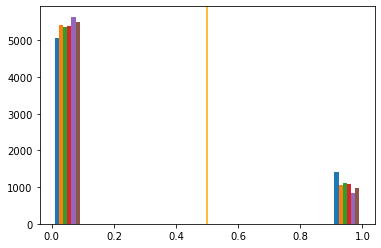

In [47]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [48]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


95.64546016059296

In [49]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [50]:
"{:0.2f}".format(pct_auc)

'97.41'

In [51]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [52]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [53]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [54]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_dense_2,n_dense_1,n_conv_3,n_conv_2,n_conv_1,maxpooling_pool_size,k_conv_3,k_conv_2,k_conv_1,dropout_2,dropout_1,avepooling_pool_size,activation_dense,activation_conv,mean,std
16,256,256,512,512,512,3,2,2,3,0.25,0.3,3,elu,relu,0.938811,0.001690
8,256,512,512,512,512,3,2,3,3,0.25,0.3,3,relu,relu,0.938210,0.001707
10,256,256,256,512,512,3,3,3,3,0.25,0.3,3,relu,relu,0.937249,0.003460
25,512,512,512,512,512,3,2,2,2,0.25,0.2,3,elu,relu,0.936648,0.002447
24,256,512,512,256,512,3,2,2,2,0.25,0.2,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.936305,0.001718
22,512,256,256,256,768,3,3,2,3,0.25,0.2,3,elu,relu,0.936151,0.002595
11,256,256,512,256,768,3,2,3,2,0.25,0.3,3,elu,relu,0.935945,0.001779
1,256,256,512,256,768,3,2,3,2,0.25,0.3,3,relu,relu,0.935859,0.000328
15,256,512,512,256,512,3,3,2,3,0.25,0.3,3,elu,relu,0.934229,0.001524
4,256,512,256,512,768,3,3,3,2,0.25,0.2,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.933440,0.003776


## Creating best model from the best param and train it for 60 epochs

Best score is: 0.9388105273246765 using {'n_dense_2': 256, 'n_dense_1': 256, 'n_conv_3': 512, 'n_conv_2': 512, 'n_conv_1': 512, 'maxpooling_pool_size': 3, 'k_conv_3': 2, 'k_conv_2': 2, 'k_conv_1': 3, 'dropout_2': 0.25, 'dropout_1': 0.3, 'avepooling_pool_size': 3, 'activation_dense': 'elu', 'activation_conv': 'relu'}list(best_param.items())

In [60]:
n_dense_2= 256
n_dense_1= 256
n_conv_3= 512
n_conv_2= 512
n_conv_1= 512
maxpooling_pool_size= 3
k_conv_3= 2
k_conv_2= 2
k_conv_1= 3
dropout_2= 0.25
dropout_1= 0.3
avepooling_pool_size= 3
activation_dense = 'elu'
activation_conv = 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [61]:
output_dir= 'model_ouput/tune-sklearn-1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [62]:
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/60
228/228 [==============================] - 8s 34ms/step - loss: 0.9290 - accuracy: 0.6087 - val_loss: 0.5920 - val_accuracy: 0.7866
Epoch 2/60
228/228 [==============================] - 7s 33ms/step - loss: 0.5357 - accuracy: 0.7956 - val_loss: 0.4419 - val_accuracy: 0.8266
Epoch 3/60
228/228 [==============================] - 7s 33ms/step - loss: 0.4041 - accuracy: 0.8524 - val_loss: 0.3407 - val_accuracy: 0.8845
Epoch 4/60
228/228 [==============================] - 7s 33ms/step - loss: 0.3545 - accuracy: 0.8677 - val_loss: 0.3052 - val_accuracy: 0.8857
Epoch 5/60
228/228 [==============================] - 7s 33ms/step - loss: 0.3254 - accuracy: 0.8804 - val_loss: 0.3100 - val_accuracy: 0.8899
Epoch 6/60
228/228 [==============================] - 7s 33ms/step - loss: 0.3043 - accuracy: 0.8872 - val_loss: 0.2844 - val_accuracy: 0.8950
Epoch 7/60
228/228 [==============================] - 7s 33ms/step - loss: 0.2807 - accuracy: 0.8964 - val_loss: 0.2526 - val_accuracy: 0.9055

Epoch 58/60
228/228 [==============================] - 8s 33ms/step - loss: 0.0773 - accuracy: 0.9720 - val_loss: 0.1527 - val_accuracy: 0.9557
Epoch 59/60
228/228 [==============================] - 8s 33ms/step - loss: 0.0735 - accuracy: 0.9737 - val_loss: 0.1595 - val_accuracy: 0.9577
Epoch 60/60
228/228 [==============================] - 8s 33ms/step - loss: 0.0768 - accuracy: 0.9726 - val_loss: 0.1647 - val_accuracy: 0.9541


In [113]:
model.load_weights(output_dir+"/weights.59.hdf5") 

In [114]:
y_hat = model.predict(X_valid)

In [115]:
len(y_hat)

6476

In [116]:
y_hat[0]

array([9.7669195e-04, 1.1186725e-06, 5.7920484e-08, 3.1209322e-07,
       1.1823817e-05, 9.9900997e-01], dtype=float32)

In [117]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

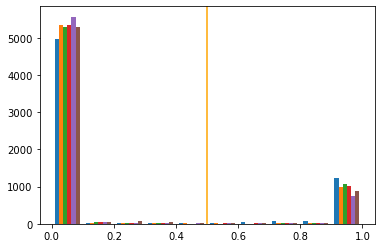

In [118]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [119]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'99.75'

In [120]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'95.61'

In [121]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [122]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [123]:
ydf.head(10)

,y_hat,y
0,"[0.001, 0.0, 0.0, 0.0, 0.0, 0.999]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.001, 0.0, 0.0, 0.0, 0.001, 0.998]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
